**Name:** YANG Yongze

**EID:** 58162280

# CS5489 - Tutorial 9
## Face Detection with CNNs

In the previous tutorial, you used an MLP to detect a face in a small image patch.
In this tutorial you will train a CNN instead of an MLP.

First we need to initialize Python.  Run the below cell.

In [25]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')
import sys
#print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)
print("Python:", sys.version, "TF:", tf.__version__)

Python: 3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)] TF: 2.6.0


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [27]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [28]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


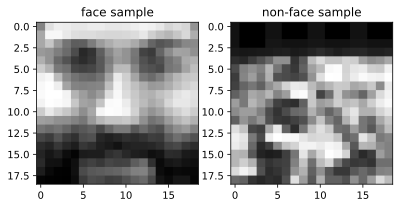

In [29]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

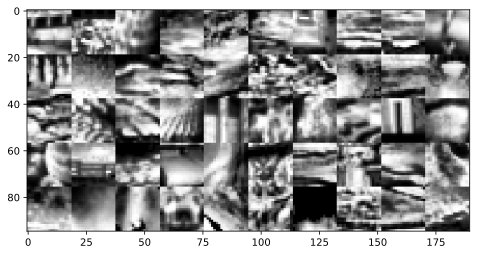

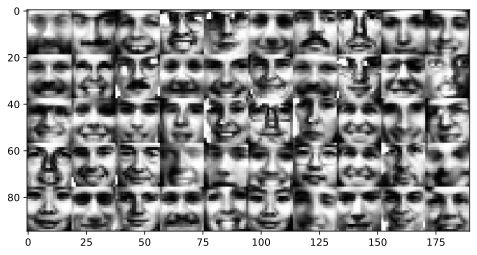

In [30]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [31]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [32]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Epoch 00016: early stopping
test accuracy: 0.6228813559322034


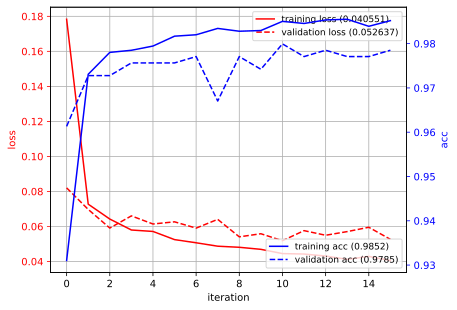

In [33]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## 2. Detection using CNN

Train an CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping, regularization, etc. to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
### CNN

K.clear_session()
random.seed(4487)
tf.random.set_seed(4487)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=0, mode='auto')
callbacks_list = [earlystop]

In [36]:
# first cnn model, the same as lecture 9
def cnn_1(learning_rate, momentum):
    nn = Sequential()
    nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
    nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
    nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
    nn.add(Flatten())
    nn.add(Dense(units=50, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return nn

Best accuracy 0.994267 using: {'learning_rate': 0.1, 'momentum': 0.5}
Epoch 1/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2145 - accuracy: 0.9132 - val_loss: 0.1080 - val_accuracy: 0.9556
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0608 - accuracy: 0.9774 - val_loss: 0.0302 - val_accuracy: 0.9914
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.0529 - val_accuracy: 0.9814
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9919 - val_loss: 0.0221 - val_accuracy: 0.9900
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.9965 - val_loss: 0.0135 - val_accuracy: 0.9928
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.0129 - val_accuracy: 0.9943
Epoch 7/100
197/197 [==============================] - 1s 3ms/step - los

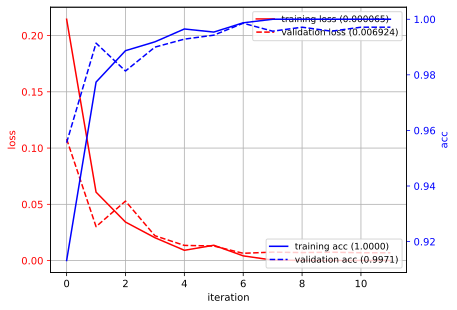

In [37]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=cnn_1, epochs=100, batch_size=32, verbose=False)

param_grid = {'learning_rate': [0.001,0.01,0.1,0.5,0.99], 'momentum': [0.1,0.2,0.5,0.7,0.99]}

grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)

grid_result = grid.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list)
print("Best accuracy %f using: %s" % (grid_result.best_score_, grid_result.best_params_))


nn = cnn_1(grid_result.best_params_['learning_rate'], grid_result.best_params_['momentum'])
history = nn.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list, epochs=100, batch_size=32)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [38]:
# second cnn model, 1 conv2D layer is removed
def cnn_2(learning_rate, momentum):
    nn = Sequential()
    nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
    nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
    nn.add(Flatten())
    nn.add(Dense(units=50, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return nn

Best accuracy 0.994107 using: {'learning_rate': 0.1, 'momentum': 0.7}
Epoch 1/100
197/197 [==============================] - 1s 3ms/step - loss: 0.2537 - accuracy: 0.8986 - val_loss: 0.0684 - val_accuracy: 0.9771
Epoch 2/100
197/197 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.9758 - val_loss: 0.0335 - val_accuracy: 0.9885
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0362 - accuracy: 0.9881 - val_loss: 0.0607 - val_accuracy: 0.9799
Epoch 4/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9874 - val_loss: 0.0504 - val_accuracy: 0.9814
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.0293 - val_accuracy: 0.9885
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.0242 - val_accuracy: 0.9900
Epoch 7/100
197/197 [==============================] - 0s 3ms/step - los

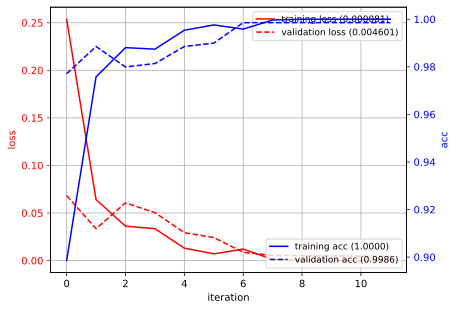

In [39]:
K.clear_session()
random.seed(4487)
tf.random.set_seed(4487)
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=cnn_2, epochs=100, batch_size=32, verbose=False)

param_grid = {'learning_rate': [0.001,0.01,0.1,0.5,0.99], 'momentum': [0.1,0.2,0.5,0.7,0.99]}

grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list)
print("Best accuracy %f using: %s" % (grid_result.best_score_, grid_result.best_params_))


nn = cnn_2(grid_result.best_params_['learning_rate'], grid_result.best_params_['momentum'])
history = nn.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list, epochs=100, batch_size=32)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [40]:
# third cnn model, 2 conv2D layers are removed
def cnn_3(learning_rate, momentum):
    nn = Sequential()
    nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
    nn.add(Flatten())
    nn.add(Dense(units=50, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return nn

Best accuracy 0.992674 using: {'learning_rate': 0.1, 'momentum': 0.2}
Epoch 1/100
197/197 [==============================] - 1s 3ms/step - loss: 0.1719 - accuracy: 0.9283 - val_loss: 0.0862 - val_accuracy: 0.9656
Epoch 2/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9723 - val_loss: 0.0561 - val_accuracy: 0.9785
Epoch 3/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9812 - val_loss: 0.0684 - val_accuracy: 0.9670
Epoch 4/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9869 - val_loss: 0.0451 - val_accuracy: 0.9842
Epoch 5/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9904 - val_loss: 0.0425 - val_accuracy: 0.9842
Epoch 6/100
197/197 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 0.0566 - val_accuracy: 0.9799
Epoch 7/100
197/197 [==============================] - 0s 2ms/step - los

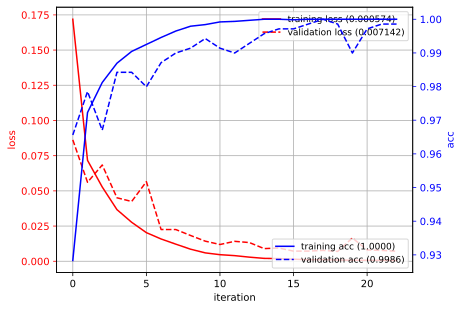

In [41]:
K.clear_session()
random.seed(4487)
tf.random.set_seed(4487)
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=cnn_3, epochs=100, batch_size=32, verbose=False)

param_grid = {'learning_rate': [0.001,0.01,0.1,0.5,0.99], 'momentum': [0.1,0.2,0.5,0.7,0.99]}

grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list)
print("Best accuracy %f using: %s" % (grid_result.best_score_, grid_result.best_params_))


nn = cnn_3(grid_result.best_params_['learning_rate'], grid_result.best_params_['momentum'])
history = nn.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list, epochs=100, batch_size=32)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

In [42]:
# fourth cnn model, convolution kernel size is changed to (3,3)
def cnn_4(learning_rate, momentum):
    nn = Sequential()
    nn.add(Conv2D(10, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(19,19,1)))
    nn.add(Conv2D(40, (3,3), strides=(2,2), activation='relu', padding='same'))
    nn.add(Conv2D(80, (3,3), strides=(1,1), activation='relu', padding='same'))
    nn.add(Flatten())
    nn.add(Dense(units=50, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return nn

Best accuracy 0.994585 using: {'learning_rate': 0.1, 'momentum': 0.7}
Epoch 1/100
197/197 [==============================] - 1s 3ms/step - loss: 0.2035 - accuracy: 0.9151 - val_loss: 0.0905 - val_accuracy: 0.9685
Epoch 2/100
197/197 [==============================] - 1s 4ms/step - loss: 0.0646 - accuracy: 0.9760 - val_loss: 0.1494 - val_accuracy: 0.9542
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0863 - accuracy: 0.9721 - val_loss: 0.0727 - val_accuracy: 0.9713
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 1.2805 - val_accuracy: 0.7407
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0637 - accuracy: 0.9788 - val_loss: 0.0260 - val_accuracy: 0.9928
Epoch 6/100
197/197 [==============================] - 1s 3ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0236 - val_accuracy: 0.9900
Epoch 7/100
197/197 [==============================] - 1s 3ms/step - los

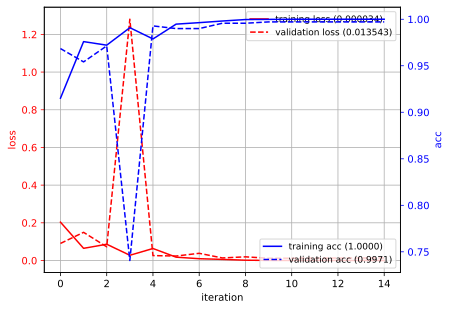

In [43]:
K.clear_session()
random.seed(4487)
tf.random.set_seed(4487)
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=cnn_4, epochs=100, batch_size=32, verbose=False)

param_grid = {'learning_rate': [0.001,0.01,0.1,0.5,0.99], 'momentum': [0.1,0.2,0.5,0.7,0.99]}

grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list)
print("Best accuracy %f using: %s" % (grid_result.best_score_, grid_result.best_params_))


nn = cnn_4(grid_result.best_params_['learning_rate'], grid_result.best_params_['momentum'])
history = nn.fit(vtrainI, vtrainYb, validation_data = validsetI, callbacks=callbacks_list, epochs=100, batch_size=32)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

_How does the CNN compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

For this tutorial, I got the following reuslt:

| No. | Best learning_rate | best momentum | best accuracy |
| ----------- | --------------- | --------------- | -------- |
| CNN 1 | 0.1 | 0.5 | 0.655    |
| CNN 2 | 0.1 | 0.7 | 0.662  |
| CNN 3 | 0.1 | 0.2 | 0.584  |
| CNN 4 | 0.1 | 0.7 | 0.660  |

For CNN1, the architecture is the same as the lecture example; 

For CNN2, the 2nd Conv2D layer (Conv2D(80, (5,5)) is removed;

For CNN3, the 2nd and 3rd Conv2D layers (Conv2D(40, (5,5) and Conv2D(80, (5,5))) are removed;

For CNN4, the convolution kernel size is changed to (3,3) from (5,5).

The 2nd CNN model, which has 2 Conv2D layers, has the highest accuracy (0.662).

In tutorial 4, I got the following result:

[ADA] Accuracy 0.638771186440678,

[XGB] Accuracy 0.6483050847457628,

[SVM] Accuracy 0.6567796610169492,

[RF] Accuracy 0.6684322033898306.

In tutorial 8(MLP), I gor the following result:

| Architecture | Best learning_rate | best momentum | best accuracy |
| ----------- | --------------- | --------------- | -------- |
| 1 layers | 0.05 | 0.9 | 0.578    |
| 2 layers | 0.05 | 0.7 | 0.646  |
| 3 layers | 0.05 | 0.7 | 0.595  |

Compared with tutorial 8, the accuracy of CNN models is higher than MLP(highest accuracy is 0.646), and is also slightly lower than classifiers in tutorial 4. 

## 3. Data Augmentation

Now use data augmentation (introduced in the last tutorial) to try to improve the accuracy.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [44]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [45]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

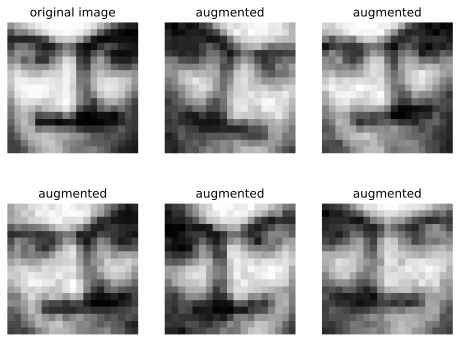

In [46]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead of "fit", we now  use the "fit_generator" method, which will pass each input through the ImageDataGenerator before sending it to the MLP.  We also disable early stopping so that the training sees more augmented data.

In [47]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=50,
#           callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 0.2616 - accuracy: 0.8871 - val_loss: 0.1114 - val_accuracy: 0.9599
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 0.1732 - accuracy: 0.9314 - val_loss: 0.1169 - val_accuracy: 0.9513
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1690 - accuracy: 0.9304 - val_loss: 0.1038 - val_accuracy: 0.9628
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1712 - accuracy: 0.9322 - val_loss: 0.1209 - val_accuracy: 0.9499
Epoch 5/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1639 - accuracy: 0.9287 - val_loss: 0.1320 - val_accuracy: 0.9413
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1726 - accuracy: 0.9318 - val_loss: 0.0991 - val_accuracy: 0.9642
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.1642 - accuracy: 0.9363 - val_loss: 0.1029 - val_accuracy: 0.9556
Epoch 

test accuracy: 0.698093220338983


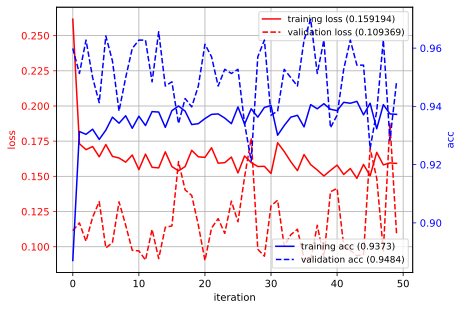

In [48]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.622 to 0.692! (your numbers may be different)

Now train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [ ]:
### INSERT YOUR CODE HERE ###

In [49]:
def addGaussNoise001(X):
    return add_gauss_noise(X, 0.01)
def addGaussNoise004(X):
    return add_gauss_noise(X, 0.04)
def addGaussNoise005(X):
    return add_gauss_noise(X, 0.05)
def addGaussNoise01(X):
    return add_gauss_noise(X, 0.1)
def addGaussNoise02(X):
    return add_gauss_noise(X, 0.2)

def addCorruptNoise001(X):
    return add_corrupt_noise(X, p=0.01)
def addCorruptNoise005(X):
    return add_corrupt_noise(X, p=0.05)
def addCorruptNoise01(X):
    return add_corrupt_noise(X, p=0.1)
def addCorruptNoise02(X):
    return add_corrupt_noise(X, p=0.2)
def addCorruptNoise05(X):
    return add_corrupt_noise(X, p=0.5)
def addCorruptNoise07(X):
    return add_corrupt_noise(X, p=0.7)

def addScaleShift001002(X):
    return add_scale_shift(X, sigma2=0.01, alpha2=0.02)
def addScaleShift0102(X):
    return add_scale_shift(X, sigma2=0.1, alpha2=0.2)
def addScaleShift0304(X):
    return add_scale_shift(X, sigma2=0.3, alpha2=0.4)
def addScaleShift0505(X):
    return add_scale_shift(X, sigma2=0.5, alpha2=0.5)




In [50]:
noises = [addGaussNoise001, addGaussNoise004, addGaussNoise005, addGaussNoise01, addGaussNoise02, addCorruptNoise001, addCorruptNoise005, addCorruptNoise01, addCorruptNoise02, addCorruptNoise05, addCorruptNoise07, addScaleShift001002, addScaleShift0102, addScaleShift0304, addScaleShift0505]

for noise in noises:
    print("---------------------------------")
    print('Using noise: ', noise.__name__)
    datagen = ImageDataGenerator(
        rotation_range=10,         # image rotation
        width_shift_range=0.05,     # image shifting
        height_shift_range=0.05,    # image shifting
        shear_range=0.05,           # shear transformation
        zoom_range=0.05,            # zooming
        horizontal_flip=True,       # horizontal flipping
        preprocessing_function=noise,  # add per-pixel noise
        data_format='channels_last')
    

    K.clear_session()
    random.seed(4487)
    tf.random.set_seed(4487)
    cnn = cnn_2(0.1, 0.7)

    history = cnn.fit(
        datagen.flow(vtrainI, vtrainYb, batch_size=100), 
        validation_data = validsetI, 
        callbacks=callbacks_list, 
        epochs=50, 
        steps_per_epoch=len(vtrainI)/100,
        verbose=False)

    predY = argmax(cnn.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy:", acc)

---------------------------------
Using noise:  addGaussNoise001
Epoch 00019: early stopping
test accuracy: 0.8379237288135594
---------------------------------
Using noise:  addGaussNoise004
Epoch 00027: early stopping
test accuracy: 0.815677966101695
---------------------------------
Using noise:  addGaussNoise005
Epoch 00013: early stopping
test accuracy: 0.809322033898305
---------------------------------
Using noise:  addGaussNoise01
Epoch 00018: early stopping
test accuracy: 0.875
---------------------------------
Using noise:  addGaussNoise02
Epoch 00024: early stopping
test accuracy: 0.7754237288135594
---------------------------------
Using noise:  addCorruptNoise001
Epoch 00020: early stopping
test accuracy: 0.8072033898305084
---------------------------------
Using noise:  addCorruptNoise005
Epoch 00023: early stopping
test accuracy: 0.847457627118644
---------------------------------
Using noise:  addCorruptNoise01
Epoch 00033: early stopping
test accuracy: 0.87288135593220

_How does CNN with data augmentation compare with your work in Tutorial 8?_ 
- **INSERT YOUR ANSWER HERE**

The results are shown below:

| Type        | param1          | param2          | accuracy (CNN) | accuracy (MLP) |
| ----------- | --------------- | --------------- | -------- | -------- |
| Gauss       | $\sigma_2$=0.01 | -               | 0.838    | 0.752    |
| Gauss       | $\sigma_2$=0.04 | -               | 0.816  | 0.839  |
| Gauss       | $\sigma_2$=0.05 | -               | 0.809  | 0.752  |
| Gauss | $\sigma_2$=0.1  | -               | 0.875  | 0.844  |
| Gauss | $\sigma_2$=0.2  | -               | 0.775  | 0.810  |
| Corrupt     | $p$=0.01         | -               | 0.807  | 0.823  |
| Corrupt     | $p$=0.05         | -               | 0.847  | 0.828  |
| Corrupt     | $p$=0.1         | -               | 0.873 | 0.808 |
| Corrupt     | $p$=0.2         | -               | 0.872 | 0.837 |
| Corrupt     | $p$=0.5         | -               | 0.877 | 0.834 |
| Corrupt     | $p$=0.7         | -               | 0.869 | 0.819 |
| Scale Shift | $\sigma_2$=0.01 | $\alpha_2$=0.02 | 0.759 | 0.821 |
| Scale Shift | $\sigma_2$=0.1 | $\alpha_2$=0.2 | 0.833 | 0.811 |
| Scale Shift | $\sigma_2$=0.3 | $\alpha_2$=0.4 | 0.798 | 0.766 |
| Scale Shift | $\sigma_2$=0.5 | $\alpha_2$=0.5 | 0.818 | 0.805 |

Adding noises always leads to higher accuracy in both tutorials. I used the same parameters and types of noises as in tutorial 8, and I got higher accuracies compared with MLP. The highest accuracy of CNN is 0.877(corrupt noise with $p$=0.5), while the highest accuracy of MLP is 0.844(gauss noise with $\sigma_2$=0.1).

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [51]:
fname = "nasa-small.png"

(210, 480)


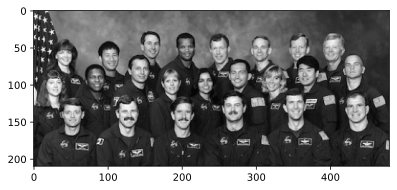

In [52]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [53]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [56]:
### YOUR CODE HERE
prednewY = argmax(cnn.predict(newI), axis=-1)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

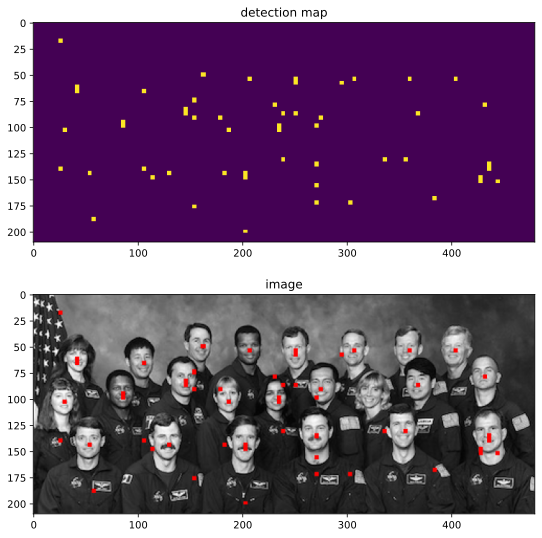

In [57]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- For this time, my CNN classifier can recognize almost all faces (except the 7th lady in the 2nd row). Compared to the last version, this classifier also recognizes multiple faces on some individual faces and incorrectly recognizes some clothing hangings as faces, but the times of occurance is appearantly reduced. Overfitting happens again, but not as bad as in tutorial 8. I think my cnn face detector still needs to adjust the parameters and optimize with the preprocessing strategy.

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/8 of the training data. Try using more data to train it!

(337, 843)


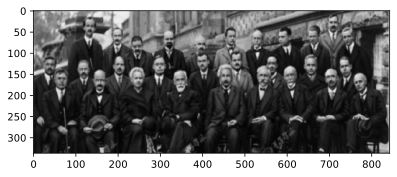

In [62]:
fname = "photo.png"
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [59]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(16560, 19, 19, 1)


In [60]:
prednewY = argmax(cnn.predict(newI, verbose=False), axis=-1)

(-0.5, 842.5, 336.5, -0.5)

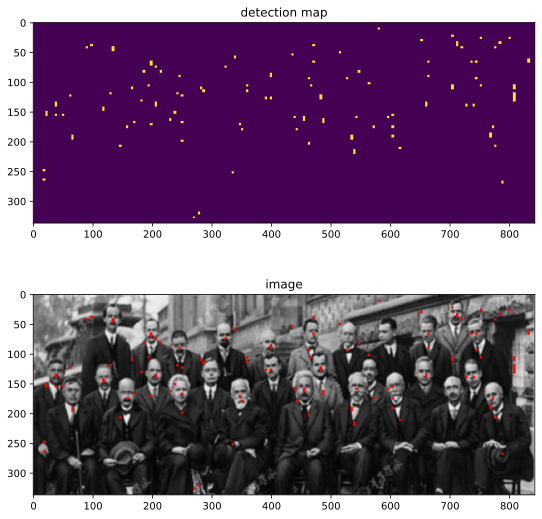

In [61]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

In this photo of mine, I used the same picture as in tutorial 8, and the similar problem arose as before. My face detector recognized multiple faces out of one and incorrectly identified items such as collars as faces, but the time of occurance is not as much is in tutorial 8. I think my cnn face detector still needs to adjust the parameters and optimize with the preprocessing strategy.